<a href="https://colab.research.google.com/github/polis-community/red-dwarf/blob/main/docs/notebooks/experiment-pca-pacmap-localmap-comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%pip install --quiet --no-cache-dir git+https://github.com/polis-community/red-dwarf.git@main
%pip install pacmap

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=553319 sha256=31c019714c1715cdbf55227291cee4c9de3b4d09d4d25bbc051b74391eb8c86e
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


statement_id     0    1    2    3    4    5    6    7    8    9   ...   36  \
participant_id                                                    ...        
1               NaN  NaN -1.0  NaN  NaN  NaN  NaN  NaN  NaN  1.0  ...  NaN   
2               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
3               NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  ...  NaN   
4               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
5               NaN  NaN -1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
136             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
137             NaN  1.0 -1.0 -1.0 -1.0  1.0  1.0  0.0  1.0  NaN  ...  0.0   
138            -1.0  1.0 -1.0 -1.0 -1.0 -1.0  1.0  1.0  1.0  1.0  ... -1.0   
139             NaN  NaN  NaN  NaN  NaN -1.0  NaN  1.0  NaN  NaN  ...  NaN   
140             1.0 -1.0  1.0  1.0  1.0 -1.0  1.0  1.0 -1.0  1.0

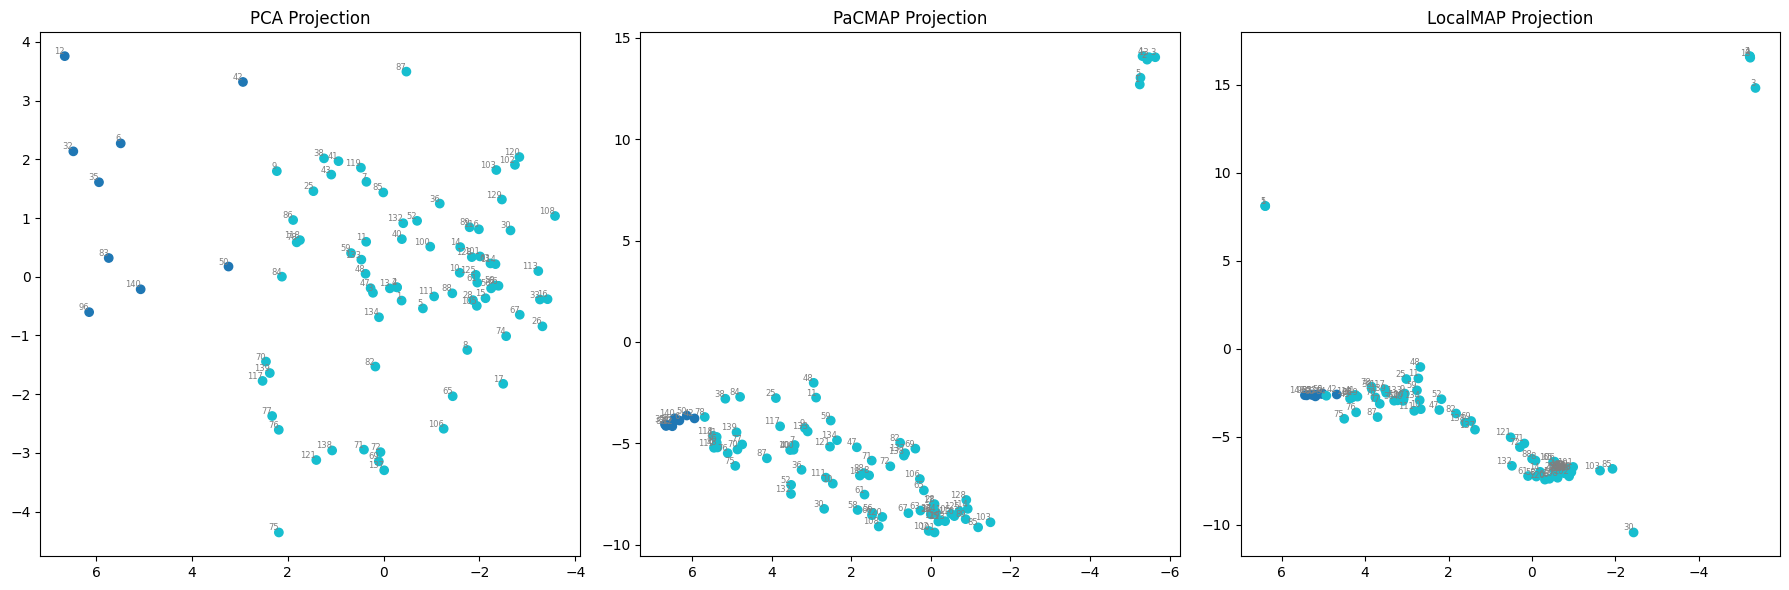

In [7]:
from reddwarf.data_loader import Loader
from reddwarf.utils.matrix import generate_raw_matrix, get_clusterable_participant_ids, simple_filter_matrix
from reddwarf.utils.polismath import extract_data_from_polismath
from reddwarf.utils.statements import process_statements

REPORT_ID="r7aybmkd3nce56sbry55t"
REPORT_ID="r9cnkypdddkmnefz8k2bn"
REPORT_ID="r8bzudrhs8j6petppicrj"

loader = Loader(polis_id=REPORT_ID)

_, _, mod_out_statement_ids, _ = process_statements(loader.comments_data)

raw_vote_matrix = generate_raw_matrix(votes=loader.votes_data)

filtered_vote_matrix = simple_filter_matrix(
    vote_matrix=raw_vote_matrix,
    mod_out_statement_ids=mod_out_statement_ids,
)

print(filtered_vote_matrix)

########

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from pacmap import PaCMAP, LocalMAP
from sklearn.decomposition import PCA
from reddwarf.sklearn.transformers import SparsityAwareScaler
import matplotlib.pyplot as plt

n_components = 2

# Setup participant mask (we won't derive our own list of active participant IDs this time)
# participant_ids_to_cluster = get_clusterable_participant_ids(raw_vote_matrix, vote_threshold=7)
# cluster_mask = [pid in participant_ids_to_cluster for pid in raw_vote_matrix.index]

# Set up participant mask and cluster labels from polismath, for comparison with default Polis.
all_clustered_participant_ids, cluster_labels = extract_data_from_polismath(loader.math_data)
cluster_mask = [pid in all_clustered_participant_ids for pid in raw_vote_matrix.index]

RANDOM_STATE = 12345

# Configure pipelines
pipelines = {
    "PCA": Pipeline([
        ("impute", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("pca", PCA(n_components=n_components, random_state=RANDOM_STATE)),
        ("scale", SparsityAwareScaler(X_sparse=raw_vote_matrix.values)),
    ]),
    "PaCMAP": Pipeline([
        ("impute", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("pacmap", PaCMAP(n_components=n_components, random_state=RANDOM_STATE)),
    ]),
    "LocalMAP": Pipeline([
        ("impute", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("localmap", LocalMAP(n_components=n_components, random_state=RANDOM_STATE)),
    ]),
    # Add more here easily
}

# Run pipelines
embeddings = {}
for name, pipe in pipelines.items():
    embeddings[name] = pipe.fit_transform(filtered_vote_matrix.values)

# Plotting
pid_labels = raw_vote_matrix.index[cluster_mask].to_list()

fig, axes = plt.subplots(1, len(embeddings), figsize=(6 * len(embeddings), 6))

# Ensure axes is always iterable
if len(embeddings) == 1:
    axes = [axes]

for ax, (name, X) in zip(axes, embeddings.items()):
    x = X[cluster_mask, 0]
    y = X[cluster_mask, 1]

    colors = cluster_labels

    ax.scatter(x, y, c=colors, cmap='tab10')
    ax.set_title(f"{name} Projection")
    for xi, yi, label in zip(x, y, pid_labels):
        ax.text(xi, yi, label, fontsize=6, color="gray", ha='right', va='bottom')
    ax.invert_xaxis()

plt.tight_layout()
plt.show()